# Regression  - Fitting a Custom Model

In previous lectures, we have discussed how to fit linear and polynomial models. But in some problems/datasets, a custom model might be a better option (e.g., better performance on unseen data). Here, we are going to learn how to fit a custom model.

Let's start by importing the needed libraries as usual, and then read a dataset. 

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")



The dataset has two columns: year and energy produced in the corresponding year. The units of the energy produced are in BTU (British thermal unit)

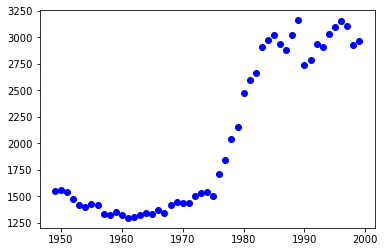

In [4]:
dt_filename = os.path.join( "data/regression", "biomass_energy.csv")

# read data in pandas frame
dataset_df = pd.read_csv(dt_filename, sep = ',')

x = dataset_df[['year']]
y = dataset_df[['energy']]

plt.scatter(x, y, c = 'b')

As it can be seen, the data does not follow a linear model and does not follow a particular a polynomial regression. Actually, it's similar to the behavior of a logistic function: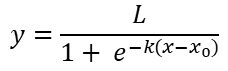

Let's fit a logistic to the available data:

In [5]:
dataset_df.head(5)

,year,energy
0,1949.0,1549.262
1,1950.0,1562.307
2,1951.0,1534.669
3,1952.0,1474.369
4,1953.0,1418.601


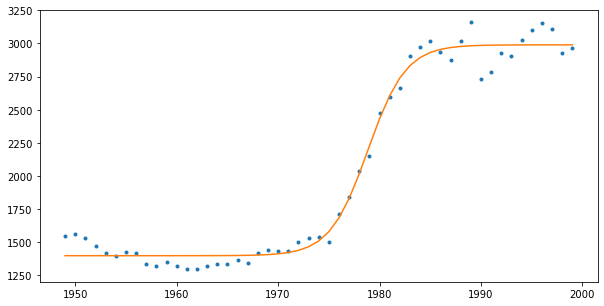

In [6]:
from scipy.optimize import minimize # Here we are going to use the minimize function 

# Logistic Function
def logistic(x,x0,L,k):
    return L/(1 + np.exp(-k*(x-x0)))

# Cost function - Minimize mean squared error
def log_cost(params, data):
    x0,L,k,offset = params
    pred = logistic(data.iloc[:,0],x0,L,k) + offset
    return np.mean( (pred-data.iloc[:,1])**2)

st_params = [1980,1500,0.001,1500]
plt.figure(figsize=(10,5))
res=minimize(log_cost,st_params,args=(dataset_df))
x0,L,k,offset = res.x # Best parameters found

# Used the model found (logistic model with a set of parameters and an offset) to predict the values
pred = logistic(dataset_df.iloc[:,0],x0,L,k) + offset

# Plot the data and the model built
plt.plot(dataset_df.iloc[:,0],dataset_df.iloc[:,1],'.')
plt.plot(dataset_df.iloc[:,0],pred)

In [10]:
# Print parameters
res.x
x0,L,k,offset

(1978.8465079251157, 1591.024313683794, 0.5340796678464257, 1398.572103465086)

Notice that, here we are just fitting a logistic function to the whole data. If we were performing model selection, for each model (e.g., linear model, logistic, and so on) we should apply k-fold cross validation and evaluate what was/were the model/models that performed better in the test set. 

Nonetheless, how confident are we of these parameters? One way to help us to validate the model is by estimating the uncertainty of it.

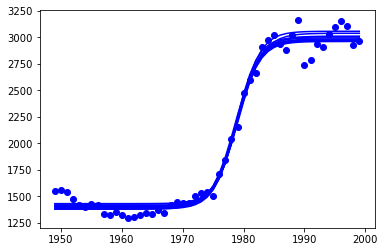

In [11]:
params = []
lines = []
pred = logistic(dataset_df.iloc[:,0],x0,L,k) + offset
residual = dataset_df.iloc[:,1]-pred

plt.scatter(x, y, color='blue')
replicas = 10

df_unc = pd.DataFrame(x)

i = 0;
for _ in range(replicas):

    rep_data = dataset_df.copy() 

    rep_data.iloc[:,1] = pred + residual*np.random.normal(size=dataset_df.shape[0])

    res=minimize(log_cost,st_params,args=(rep_data))
    x0,L,k,offset = res.x
    pred_replica = logistic(dataset_df.iloc[:,0],x0,L,k)+offset

    df_unc =  pd.concat([df_unc, pred_replica], axis=1) 
    df_unc
    i = i + 1;
    plt.plot(dataset_df.iloc[:,0], df_unc.iloc[:,i] , c = 'blue')
    

# Regression - Boston house prices

## Linear Regression

Based on what we've have discussed so far let's create a linear regression to predict the prices of the houses. Here, we are going to use the Boston house prices dataset available at scikit learn and so we can import it as follows:

In [21]:
from sklearn.datasets import load_boston

seed = 10
dt_filename = os.path.join( "data/regression", "biomass_energy.csv")

# read data in pandas frame
dataset_df = pd.read_csv(dt_filename, sep = ',')

In [23]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are 2 important assumptions in linear regression:

- input variables are independent
- input variables have a linear relationship with the output variable

So we need to find what variable is highly correlated with the price of the houses.

In [22]:
corrmat = df.corr().abs()
pearson = corrmat['price']
pearson.sort_values(axis = 0, ascending = False)

KeyError: 'price'

Text(0, 0.5, 'Target')

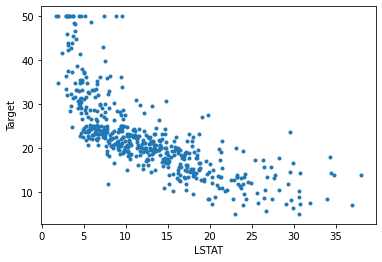

In [14]:
plt.plot(df['LSTAT'], df['price'], '.')
plt.xlabel('LSTAT')
plt.ylabel('Target')

Since LSTAT has the stronger correlation with the target (as you can see in previous result), let's use it to build our linear regression model (linear regression because we only have 1 input variable).

In [15]:
from sklearn import linear_model

def regression_f(input, price):
    model = linear_model.LinearRegression()
    return -1*cross_val_score(model, input, price, scoring='neg_mean_squared_error', cv=10).mean()

test_error = regression_f(df[['LSTAT']], df[['price']])

print(f'Estimated true error (test error): {test_error}') 

Estimated true error (test error): 41.828958072164035


Let's build a model based on a training set:

In [16]:
from sklearn import linear_model
seed = 40

df_tmp = df[['LSTAT', 'price']]

train_set, test_set = train_test_split(df_tmp, test_size = 0.2, random_state = seed)

model = linear_model.LinearRegression()
model.fit(train_set[['LSTAT']], train_set[['price']])


LinearRegression()

In [17]:
# Coefficient
model.coef_

array([[-0.996635]])

In [18]:
# Intercept
model.intercept_

array([34.77184067])

So the model created was $$y = 34.77 -0.996X $$

Now let's plot test data set and the predicted values

Text(0, 0.5, 'Target')

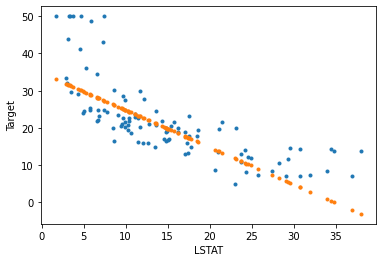

In [19]:
# Apply model to Training Set
y_pred_test = model.predict(test_set[['LSTAT']])

plt.plot(test_set['LSTAT'], test_set['price'], '.')
plt.plot(test_set['LSTAT'], y_pred_test, '.' )

plt.xlabel('LSTAT')
plt.ylabel('Target')

Besides estimating the uncertainty, we can also observe the distribution of residuals values in order understand if there is room for improvement or not. 

The residuals are the difference between the data and the predictions 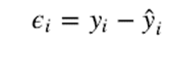

Text(0, 0.5, 'Residual Value')

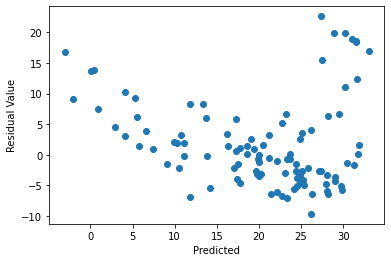

In [20]:
# Check Residuals
residuals = test_set[['price']] - y_pred_test

plt.scatter(y_pred_test, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual Value')

positive values for the residual (on the y-axis) means the prediction was too low, and negative values mean the prediction was too high; 0 means the guess was exactly correct.

Ideally, the Residual Plot should be normally distributed
1. Residuals are pretty symmetrically distributed, tending to cluster towards the middle of the plot.
2. they’re clustered around the lower single digits of the y-axis (e.g., 0.5 or 1.5, not 30 or 150).
3. in general, there aren’t any clear patterns.

Examples of residual plots that meet previous requirements: 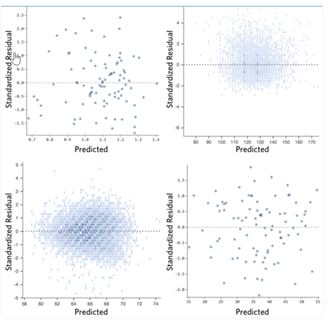

In our case, the Residual Plot does not satisfy previous requirements, which indicates that there is room for improving our model.

# Multiple Linear Regression

Now let's try multiple linear regression meaning that we are going to use more than one feature.

Let's see if we can improve our model by adding some aditional features:

1. Add the second highly correlated feature - RM
2. Use all features


In [17]:
def regression_f(input, price):
    model = linear_model.LinearRegression()
    return -1*cross_val_score(model, input, price, scoring='neg_mean_squared_error', cv=10).mean()


test_error = regression_f(df[['LSTAT', 'RM']], df[['price']])
print(f'Estimated true error (test error): {test_error}')

Estimated true error (test error): 38.38482773415987


In [15]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Now let's use all features:

In [16]:
test_error = regression_f(df.drop(['price'], axis = 1), df[['price']])
print(f'Estimated true error (test error): {test_error}')

Estimated true error (test error): 34.705255944524936


Now, let's try to apply a polynomial regression (simple and multiple). For that, we need to transform the input variables to map to the function we want to use. For example, a third degree polynomial:

In [18]:
polynomial_features = PolynomialFeatures(degree = 3)

In [19]:
polynomial_features = PolynomialFeatures(degree = 3)

test_error = regression_f(polynomial_features.fit_transform(df[['LSTAT']]), df[['price']])
print(f'Estimated true error (test error): {test_error}')

Estimated true error (test error): 32.12260415319025


Now let's see what happens if we apply third degree polynomial to all input features.

In [20]:
test_error = regression_f(polynomial_features.fit_transform(df.drop(['price'], axis = 1)), df[['price']])
print(f'Estimated true error (test error): {test_error}')

Estimated true error (test error): 7285640132.648656


Just because we add all features to train the model does not implies that we will improve the performance of the model. Actually, the opposite may happen.

Finally, let's try to apply a third degree polynomial to LSTAT and RM features

In [21]:
polynomial_features = PolynomialFeatures(degree = 3)
test_error = regression_f(polynomial_features.fit_transform(df[['LSTAT', 'RM']]), df[['price']])
print(f'Estimated true error (test error): {test_error}')

Estimated true error (test error): 24.802089947933755


Exercise: Plot the Residual plot and discuss the results